In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('../data/gene_expression.csv')
df.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


In [5]:
# Features and target
X = df.drop('Cancer Present', axis=1)
y = df['Cancer Present']

X.shape, y.shape

((3000, 2), (3000,))

In [6]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20
    , random_state=27
)

In [7]:
# Define pipeline steps
pipe = Pipeline([
    ('scaler', StandardScaler())
    , ('knn', KNeighborsClassifier())
])

In [9]:
# Parameter grid for n_neighbors
param_grid = {'knn__n_neighbors': 
              np.arange(1, 21)}

# GridSearchCV
grid = GridSearchCV(
    estimator=pipe
    , param_grid=param_grid
    , cv=5
    , scoring='accuracy'
    , return_train_score=True
)

%timeit
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
             return_train_score=True, scoring='accuracy')

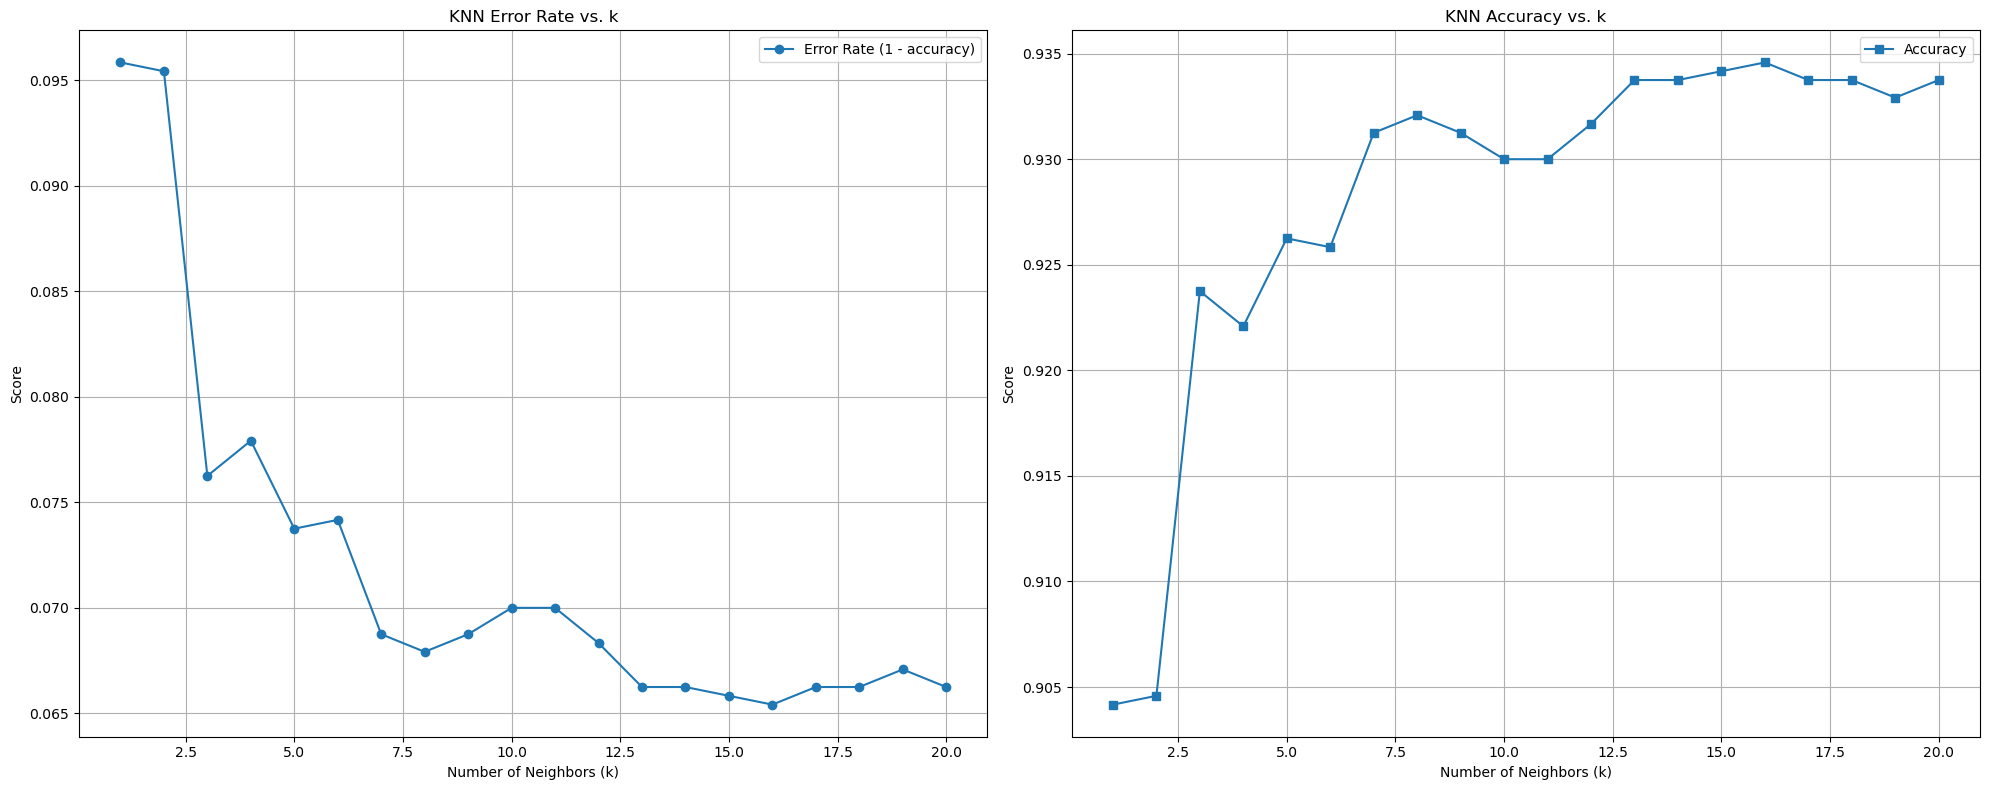

In [10]:
# Plot of K-vals (x-axis) and Error / Accuracy (y-axes)
neighbors = param_grid['knn__n_neighbors']
test_scores = grid.cv_results_['mean_test_score']

# Create a figure with two subplots side-by-side (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # Adjust figsize for wider plots

# First subplot: Error Rate vs. k
axes[0].plot(
    neighbors, 1 - test_scores
    , marker='o'
    , label='Error Rate (1 - accuracy)'
)
axes[0].set_xlabel('Number of Neighbors (k)')
axes[0].set_ylabel('Score')
axes[0].set_title('KNN Error Rate vs. k')
axes[0].legend()
axes[0].grid(True)

# Second subplot: Accuracy vs. k
axes[1].plot(
    neighbors, test_scores
    , marker='s'
    , label='Accuracy'
)
axes[1].set_xlabel('Number of Neighbors (k)')
axes[1].set_ylabel('Score')
axes[1].set_title('KNN Accuracy vs. k')
axes[1].legend()
axes[1].grid(True)

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

In [11]:
# Best n_neighbors
best_k = grid.best_params_['knn__n_neighbors']
print(f'Best n_neighbors: {best_k}')
print(f'Best cross-validated accuracy: {grid.best_score_:.3f}')

# Use best estimator for predictions
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

Best n_neighbors: 16
Best cross-validated accuracy: 0.935


In [12]:
print("Test Set Accuracy:"
      , accuracy_score(y_test, y_pred))

Test Set Accuracy: 0.9383333333333334


In [13]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[273,  15],
       [ 22, 290]])

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       288
           1       0.95      0.93      0.94       312

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



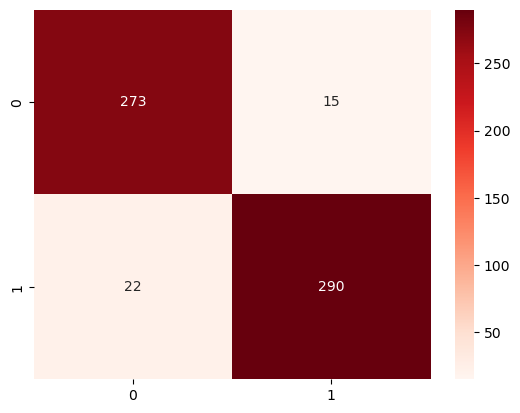

In [15]:
sns.heatmap(
    cm, annot=True, fmt="d", cmap='Reds'
);

In [16]:
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=16))])

In [18]:
grid.score

<bound method BaseSearchCV.score of GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
             return_train_score=True, scoring='accuracy')>

In [ ]:
"""
Since the elbow method is showing that a 
K value of eight will get just as good of 
an error and accuracy but with less complexity,
than 15 neighbors fitting with the lower 
neighbors is likely more ideal;
"""

In [19]:
# Create pipeline with k=8
pipe_k8 = Pipeline([
    ('scaler', StandardScaler())
    , ('knn', KNeighborsClassifier(n_neighbors=8))
])

# Fit pipeline on training data
pipe_k8.fit(X_train, y_train)

# Predict on test data
y_pred_k8 = pipe_k8.predict(X_test)

In [20]:
# Evaluate as before
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Test Set Accuracy:", accuracy_score(y_test, y_pred_k8))
print('\n')
print("Classification Report:\n",classification_report(y_test, y_pred_k8))
print('\n')
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_k8))

Test Set Accuracy: 0.9283333333333333


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.93       288
           1       0.94      0.92      0.93       312

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600



Confusion Matrix:
 [[271  17]
 [ 26 286]]


In [21]:
cm8 = confusion_matrix(y_test, y_pred_k8)
cm8

array([[271,  17],
       [ 26, 286]])

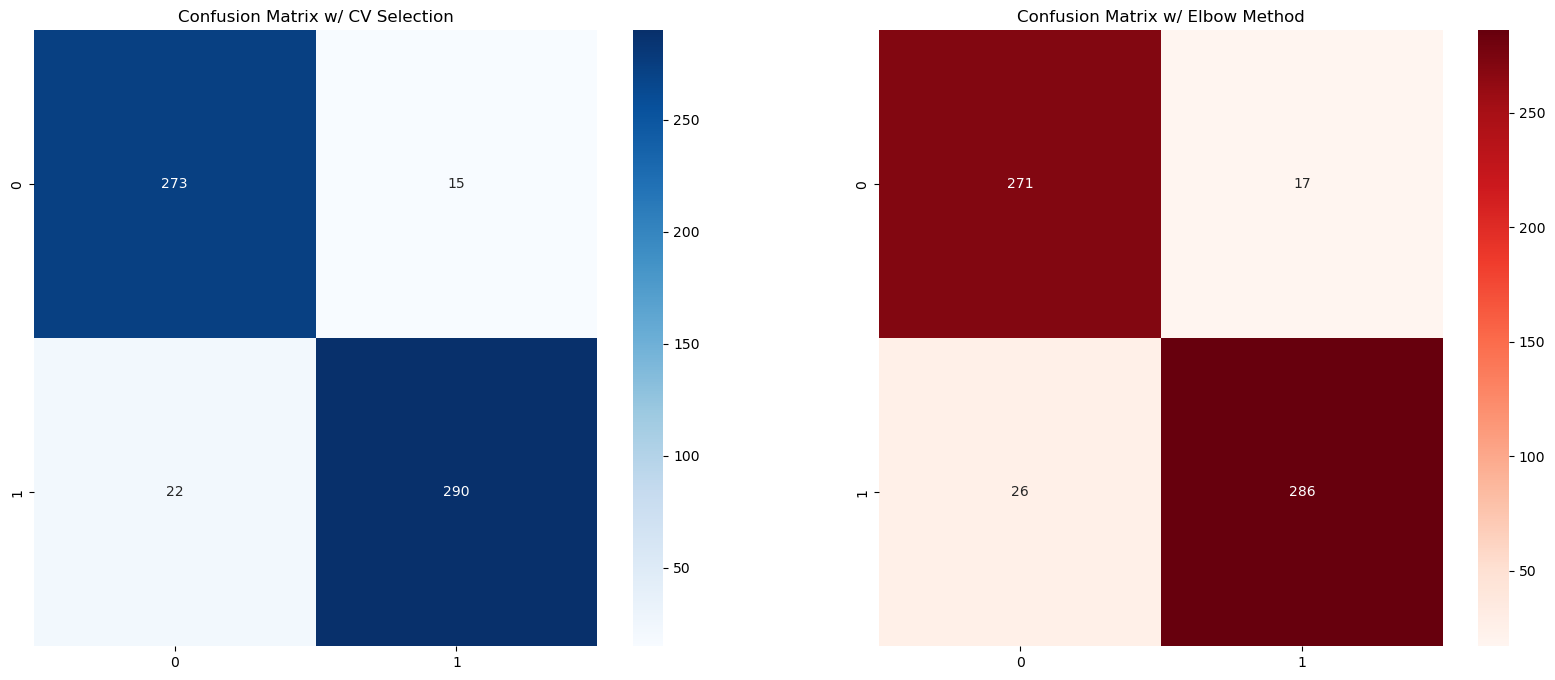

In [22]:
# Side-by-side Confusion Matrices for CV and Elbow Methods (minimal error slippage for major efficiency gained;)

fig, ax = plt.subplots(1,2, figsize=(20,8))

sns.heatmap(
    cm, annot=True, fmt="d", ax=ax[0], cmap='Blues')

sns.heatmap(
    cm8, annot=True, fmt="d", ax=ax[1], cmap='Reds')

ax[0].set_title("Confusion Matrix w/ CV Selection")
ax[1].set_title("Confusion Matrix w/ Elbow Method")

plt.show();

In [ ]:
# Bonus - set up a 'normalized' CM in px - extra bonus: with the actal cm col headers;

# cm_normd = confusion_matrix(y_test, y_pred_final, normalize='true')
# cm_normd

# cm_normd_df = pd.DataFrame(
#     cm_normd
#     , columns=["Predicted Negative", "Predicted Positive"]
#     , index=["Actual Negative", "Actual Positive"]
# )
# cm_normd_df

In [26]:
# Bonus 2: Set up side-by-side 'normalized' confusion matrices;

In [23]:
pipe_k8.score

<bound method Pipeline.score of Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=8))])>

In [24]:
print("Test Set Accuracy w/ CV Selection:\n", accuracy_score(y_test, y_pred))
print('\n')
print("Test Set Accuracy w/ Elbow Method:\n", accuracy_score(y_test, y_pred_k8))

Test Set Accuracy w/ CV Selection:
 0.9383333333333334


Test Set Accuracy w/ Elbow Method:
 0.9283333333333333


In [25]:
print("Confusion Matrix w/ CV Selection:\n", cm)
print('\n')
print("Confusion Matrix w/ Elbow Method:\n", cm8)

Confusion Matrix w/ CV Selection:
 [[273  15]
 [ 22 290]]


Confusion Matrix w/ Elbow Method:
 [[271  17]
 [ 26 286]]
